In [357]:
import soccerdata as sd
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm
import numpy as np

In [358]:
df1 = pd.read_csv("FootballData_ENG-Premier League.csv")
df2 = pd.read_csv("FootballData_ITA-Serie A.csv")
df3 = pd.read_csv("FootballData_ESP-La Liga.csv")
df4 = pd.read_csv("FootballData_GER-Bundesliga.csv")
df5 = pd.read_csv("FootballData_FRA-Ligue 1.csv")
df = pd.concat([df1,df2,df3,df4,df5])
df
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date')

In [359]:
df.select_dtypes(["object"])

,Div,Time,HomeTeam,AwayTeam,FTR,HTR,Referee
8122,F1,NaN,Nantes,Monaco,H,NaN,NaN
8474,F1,NaN,Strasbourg,Auxerre,D,NaN,NaN
8467,F1,NaN,Bordeaux,Paris SG,H,NaN,NaN
8468,F1,NaN,Caen,Metz,D,NaN,NaN
8469,F1,NaN,Lille,Martigues,D,NaN,NaN
...,...,...,...,...,...,...,...
3480,E0,14:00,West Ham,Burnley,D,A,D England
2725,D1,14:30,Bochum,Freiburg,A,A,NaN
3817,E0,20:00,Chelsea,Newcastle,H,D,J Brooks
3535,I1,19:45,Lazio,Udinese,A,D,NaN


In [360]:
df = df.drop(["Unnamed: 0.1","Div","Time","Referee"], axis=1)

In [361]:
# Dropearemos todas las columnas que tienen menos del 50% de los datos
porcentaje_minimo = 0.5 * len(df)
df = df.dropna(axis=1, thresh=int(porcentaje_minimo))
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,IWA,WHH,WHD,WHA,VCH,VCD,VCA,LBH,LBD,LBA
8122,1993-07-23,Nantes,Monaco,1.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8474,1993-07-24,Strasbourg,Auxerre,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8467,1993-07-24,Bordeaux,Paris SG,1.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8468,1993-07-24,Caen,Metz,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8469,1993-07-24,Lille,Martigues,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480,2024-03-10,West Ham,Burnley,2.0,2.0,D,0.0,2.0,A,22.0,...,NaN,1.65,4.0,4.80,1.62,3.9,5.00,NaN,NaN,NaN
2725,2024-03-10,Bochum,Freiburg,1.0,2.0,A,0.0,1.0,A,18.0,...,NaN,2.25,3.6,3.00,2.20,3.6,3.10,NaN,NaN,NaN
3817,2024-03-11,Chelsea,Newcastle,3.0,2.0,H,1.0,1.0,D,12.0,...,NaN,1.85,4.2,3.50,1.90,3.8,3.50,NaN,NaN,NaN
3535,2024-03-11,Lazio,Udinese,1.0,2.0,A,0.0,0.0,D,18.0,...,NaN,1.91,3.5,4.00,1.83,3.1,4.33,NaN,NaN,NaN


In [362]:
df_ceros = df.fillna(-1)

for columna in df_ceros.columns:
    if columna not in df.select_dtypes(["object"]).keys():
        nombre_columna_indicadora = columna + '_presente'
        df[nombre_columna_indicadora] = df_ceros[columna].apply(lambda x: 1 if x != -1 else 0)
df = df.fillna(0)

In [8]:
def encontrar_min_feature(row):
    max_value = row.min()
    max_features = row[row == max_value].index.tolist()  # Obtener todas las características con el valor máximo
    if len(max_features) == 1:
        return max_features[0]  # Si solo hay una característica con el valor máximo, retornar su nombre
    else:
        return 'D'  # Si hay un empate, retornar 'Draw'

# Crear una nueva columna con la característica que tiene el valor máximo, manejando empates
df["B365"] = df[['B365H', 'B365D', 'B365A']].apply(encontrar_min_feature, axis=1)
df["BW"] = df[['BWH', 'BWD', 'BWA']].apply(encontrar_min_feature, axis=1)
df["IW"] = df[['IWH', 'IWD', 'IWA']].apply(encontrar_min_feature, axis=1)
df["WH"] = df[['WHH', 'WHD', 'WHA']].apply(encontrar_min_feature, axis=1)
df["VC"] = df[['VCH', 'VCD', 'VCA']].apply(encontrar_min_feature, axis=1)
df["LB"] = df[['LBH', 'LBD', 'LBA']].apply(encontrar_min_feature, axis=1)

In [9]:
def comparacion_resultado(row):
    if row[0] == 0:
        return -1
    Resultado = row[1][-1]
    if Resultado == row[2]:
        return 1
    else:
        return 0
    

df["B365_correcto"] = df[["B365H_presente","B365","FTR"]].apply(comparacion_resultado, axis=1)
df["BW_correcto"] = df[["BWH_presente","BW","FTR"]].apply(comparacion_resultado, axis=1)
df["IW_correcto"] = df[["IWH_presente","IW","FTR"]].apply(comparacion_resultado, axis=1)
df["WH_correcto"] = df[["WHH_presente","WH","FTR"]].apply(comparacion_resultado, axis=1)
df["VC_correcto"] = df[["VCH_presente","VC","FTR"]].apply(comparacion_resultado, axis=1)
df["LB_correcto"] = df[["LBH_presente","LB","FTR"]].apply(comparacion_resultado, axis=1)

C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] == 0:
C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Resultado = row[1][-1]
C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Resultado == row[2]:
C:\Users\gfuen\AppData\Local\Temp\

In [10]:
# Estadísticas
B365 = sum(df["B365_correcto"]==1) / sum(df["B365_correcto"]>=0)
BW = sum(df["BW_correcto"]==1) / sum(df["BW_correcto"]>=0)
IW = sum(df["IW_correcto"]==1) / sum(df["IW_correcto"]>=0)
WH = sum(df["WH_correcto"]==1) / sum(df["WH_correcto"]>=0)
VC = sum(df["VC_correcto"]==1) / sum(df["VC_correcto"]>=0)
LB = sum(df["LB_correcto"]==1) / sum(df["LB_correcto"]>=0)

print(f"B365 predichos :{B365}")
print(f"BW predichos :{BW}")
print(f"IW predichos :{IW}")
print(f"WH predichos :{WH}")
print(f"VC predichos :{VC}")
print(f"LB predichos :{LB}")

B365 predichos :0.5294209417821576
BW predichos :0.5294564056439373
IW predichos :0.5252283022067195
WH predichos :0.5281647339119442
VC predichos :0.5323482663213045
LB predichos :0.524517280545189


In [11]:
df = df.drop(['"B365"_correcto', 'BW_correcto', 'IW_correcto', 'WH_correcto', 'VC_correcto', 'LB_correcto',
              "B365","BW","IW","WH","VC","LB"], axis = 1)

# Modelo 1: Solo tasas de apuestas

In [363]:
casas = ["B365","BW","IW","WH","VC","LB"]
col = []
for i in range(len(casas)):
    col.append(casas[i]+"H")
    col.append(casas[i]+"D")
    col.append(casas[i]+"A")
    col.append(casas[i]+"H_presente")
    col.append(casas[i]+"D_presente")
    col.append(casas[i]+"A_presente")

In [390]:
X = df.get(col)
y = df['FTR']

y = pd.get_dummies(y,dtype=int)

In [391]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [392]:
X_train

,B365H,B365D,B365A,B365H_presente,B365D_presente,B365A_presente,BWH,BWD,BWA,BWH_presente,...,VCA,VCH_presente,VCD_presente,VCA_presente,LBH,LBD,LBA,LBH_presente,LBD_presente,LBA_presente
5811,3.20,3.50,2.20,1,1,1,3.10,3.50,2.25,1,...,2.25,1,1,1,0.00,0.0,0.00,0,0,0
3738,2.10,3.25,3.80,1,1,1,2.05,3.30,3.90,1,...,4.00,1,1,1,2.05,3.1,3.80,1,1,1
6040,1.90,3.25,4.00,1,1,1,1.85,3.35,3.80,1,...,4.00,1,1,1,1.72,3.2,4.33,1,1,1
10457,1.85,3.50,4.50,1,1,1,1.83,3.60,4.40,1,...,4.10,1,1,1,0.00,0.0,0.00,0,0,0
898,0.00,0.00,0.00,0,0,0,0.00,0.00,0.00,0,...,0.00,0,0,0,0.00,0.0,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5040,2.20,3.40,3.20,1,1,1,2.10,3.25,3.35,1,...,3.10,1,1,1,2.10,3.2,3.00,1,1,1
1941,3.40,3.75,2.05,1,1,1,3.40,3.60,2.00,1,...,2.10,1,1,1,3.30,3.8,2.00,1,1,1
7297,0.00,0.00,0.00,0,0,0,0.00,0.00,0.00,0,...,0.00,0,0,0,0.00,0.0,0.00,0,0,0
8386,1.65,4.00,5.25,1,1,1,1.70,4.00,4.60,1,...,5.25,1,1,1,0.00,0.0,0.00,0,0,0


In [393]:
y_train

,A,D,H
5811,0,1,0
3738,0,1,0
6040,0,0,1
10457,0,0,1
898,0,1,0
...,...,...,...
5040,0,0,1
1941,0,0,1
7297,1,0,0
8386,0,0,1


In [394]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


drop = 0.0
size_layer = 32
batch_size = 64
epoch = 10
model = Sequential([
    Dense(size_layer, activation='relu',
          input_shape=(X.shape[1],), use_bias=True,),
    Dense(32, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(y.shape[1], activation='softmax', use_bias=True,)
])
# # Compilamos el modelo
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
# adam = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.99, beta_2=0.9999)

# hinge = tf.keras.losses.CategoricalHinge()
# focal_cross = tf.keras.losses.CategoricalFocalCrossentropy(
#     alpha=0.2, gamma=2, from_logits=False, label_smoothing=0.0)
# cross = tf.keras.losses.CategoricalCrossentropy(
#     from_logits=False, label_smoothing=0.0)

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/10
679/679 [==============================] - 1s 944us/step - loss: 1.0063 - categorical_accuracy: 0.5104 - val_loss: 0.9942 - val_categorical_accuracy: 0.5188
Epoch 2/10
679/679 [==============================] - 1s 1ms/step - loss: 1.0008 - categorical_accuracy: 0.5131 - val_loss: 0.9940 - val_categorical_accuracy: 0.5191
Epoch 3/10
679/679 [==============================] - 1s 825us/step - loss: 1.0003 - categorical_accuracy: 0.5132 - val_loss: 0.9930 - val_categorical_accuracy: 0.5200
Epoch 4/10
679/679 [==============================] - 1s 824us/step - loss: 0.9993 - categorical_accuracy: 0.5144 - val_loss: 0.9932 - val_categorical_accuracy: 0.5197
Epoch 5/10
679/679 [==============================] - 1s 878us/step - loss: 0.9995 - categorical_accuracy: 0.5137 - val_loss: 0.9937 - val_categorical_accuracy: 0.5200
Epoch 6/10
679/679 [==============================] - 1s 836us/step - loss: 0.9991 - categorical_accuracy: 0.5139 - val_loss: 0.9936 - val_categorical_accuracy: 0

1357/1357 [==============================] - 1s 502us/step


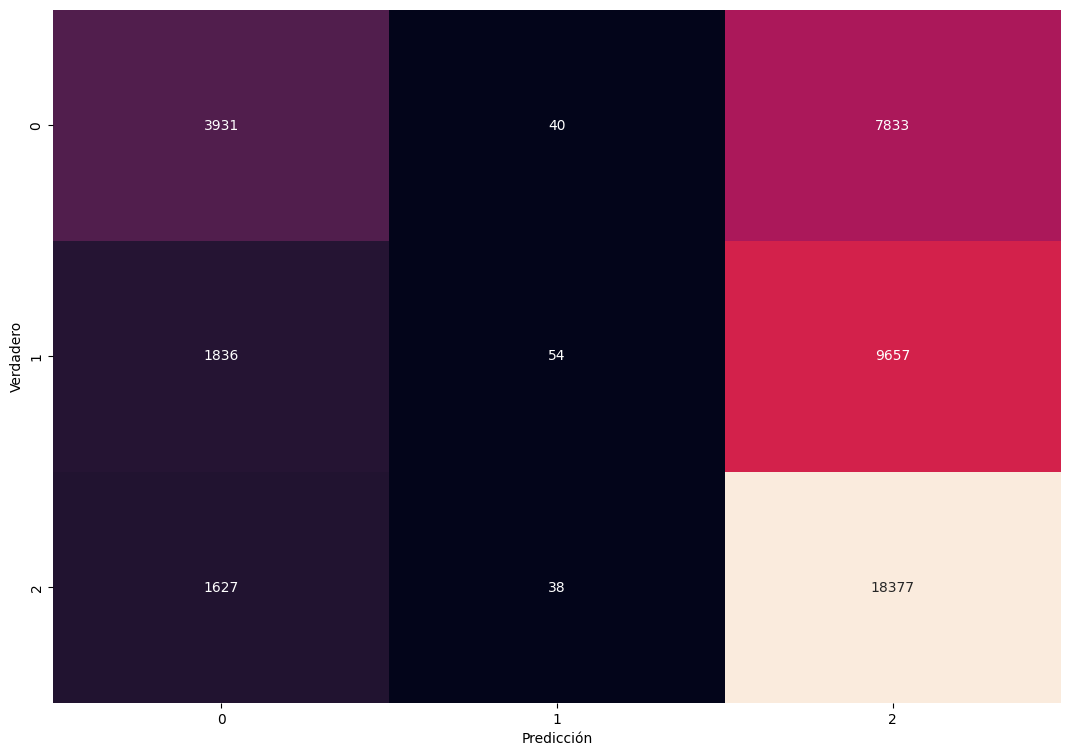

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


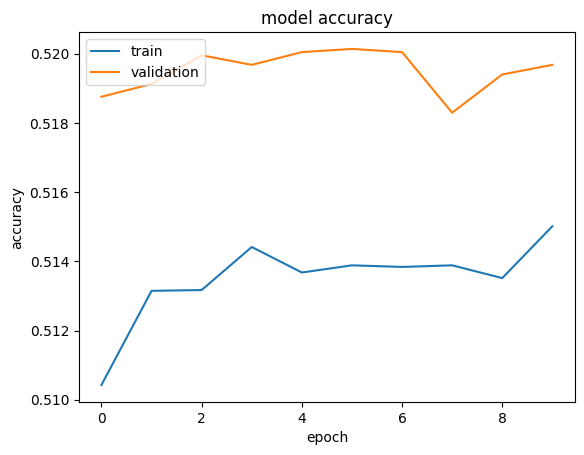

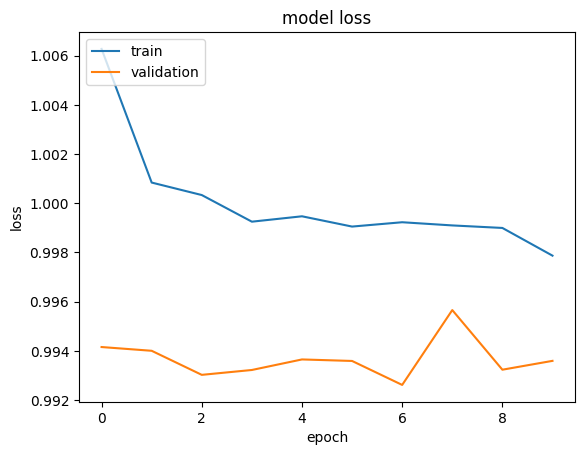

In [395]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from copy import deepcopy

y_prob = model.predict(X_train)
y_test_metrics = np.argmax(y_train, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred_copy = deepcopy(y_pred)
y_test_metrics_copy = deepcopy(y_test_metrics)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
plt.figure(figsize=(13, 9))

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Modelo 2: Empezar a usar datos de apuestas pasados

In [396]:
df.keys()

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'LBH', 'LBD',
       'LBA', 'Date_presente', 'FTHG_presente', 'FTAG_presente',
       'HTHG_presente', 'HTAG_presente', 'HS_presente', 'AS_presente',
       'HST_presente', 'AST_presente', 'HF_presente', 'AF_presente',
       'HC_presente', 'AC_presente', 'HY_presente', 'AY_presente',
       'HR_presente', 'AR_presente', 'B365H_presente', 'B365D_presente',
       'B365A_presente', 'BWH_presente', 'BWD_presente', 'BWA_presente',
       'IWH_presente', 'IWD_presente', 'IWA_presente', 'WHH_presente',
       'WHD_presente', 'WHA_presente', 'VCH_presente', 'VCD_presente',
       'VCA_presente', 'LBH_presente', 'LBD_presente', 'LBA_presente'],
      dtype='object')

In [397]:
casas = ["B365", "BW", "IW", "WH", "VC", "LB"]
features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
            'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'LBH', 'LBD',
            'LBA','B365H_presente', 'B365D_presente',
            'B365A_presente', 'BWH_presente', 'BWD_presente', 'BWA_presente',
            'IWH_presente', 'IWD_presente', 'IWA_presente', 'WHH_presente',
            'WHD_presente', 'WHA_presente', 'VCH_presente', 'VCD_presente',
            'VCA_presente', 'LBH_presente', 'LBD_presente', 'LBA_presente']

In [446]:
def get_features(data, features):
    return pd.DataFrame(data[features]).T


def search_apuestas(i, df, last_games, features):
    team_home = df.iloc[i]["HomeTeam"]
    team_away = df.iloc[i]["AwayTeam"]
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match_home1 = df[df["HomeTeam"] == team_home]
    df_match_home2 = df[df["AwayTeam"] == team_home]
    df_match_away1 = df[df["HomeTeam"] == team_away]
    df_match_away2 = df[df["AwayTeam"] == team_away]

    merged_df_home = pd.concat([df_match_home1, df_match_home2])
    merged_df_home.drop_duplicates(inplace=True)
    merged_df_home = merged_df_home.sort_values(by="Date", ascending=False)

    merged_df_away = pd.concat([df_match_away1, df_match_away2])
    merged_df_away.drop_duplicates(inplace=True)
    merged_df_away = merged_df_away.sort_values(by="Date", ascending=False)

    # El index 0 es el partido, por lo que iteramos desde el 1
    data_home = pd.DataFrame()
    data_away = pd.DataFrame()
    if len(merged_df_home) < last_games or len(merged_df_away)<last_games:
        return pd.DataFrame(), False

    for j in range(last_games):
        if team_home == merged_df_home.iloc[j]["HomeTeam"]:
            d = get_features(merged_df_home.iloc[j], features)
            d["played_home"] = 1
            d["played_away"] = 0
            data_home = pd.concat([data_home, d.T],axis=1)

        elif team_home == merged_df_home.iloc[j]["AwayTeam"]:
            d = get_features(merged_df_home.iloc[j], features)
            d["played_home"] = 0
            d["played_away"] = 1
            data_home = pd.concat([data_home, d.T],axis=1)
        

    for j in range(last_games):
        if team_away == merged_df_away.iloc[j]["HomeTeam"]:
            d = get_features(merged_df_away.iloc[j], features)
            d["played_home"] = 1
            d["played_away"] = 0
            data_away = pd.concat([data_away, d.T],axis=1)
        elif team_away == merged_df_away.iloc[j]["AwayTeam"]:
            d = get_features(merged_df_away.iloc[j], features)
            d["played_home"] = 0
            d["played_away"] = 1
            data_away = pd.concat([data_away, d.T],axis=1)

    data = pd.concat([data_home.T, data_away.T])

    data = data.reset_index(drop=True)

    data = data.stack().to_frame().T

    df_f = pd.DataFrame()

    for j in range(1,last_games*2):
        parte = data[j].add_suffix(f"_{j}",axis=1)
        df_f = pd.concat([df_f,parte],axis=1)

    return df_f, df.iloc[i]["FTR"]

prueba = search_apuestas(35000, df.head(35000+1), 5, features)
prueba[0]


,B365H_1,B365D_1,B365A_1,BWH_1,BWD_1,BWA_1,IWH_1,IWD_1,IWA_1,WHH_1,...,WHD_presente_9,WHA_presente_9,VCH_presente_9,VCD_presente_9,VCA_presente_9,LBH_presente_9,LBD_presente_9,LBA_presente_9,played_home_9,played_away_9
0,1.17,7.0,16.0,1.16,7.75,13.5,1.2,6.5,10.3,1.17,...,1,1,1,1,1,1,1,1,1,0


In [448]:
# Programa lineal
last_games = 15
resultados = []
for i in tqdm(range(len(df))):
    info = search_apuestas(i,df.head(i+1),last_games,features)
    resultados.append(info)

100%|██████████| 54242/54242 [59:02<00:00, 15.31it/s]  


In [450]:
X = pd.DataFrame()
X_aux  =[]
y = []
for i in tqdm(range(len(resultados))):
    X_aux.append(resultados[i][0])
    if resultados[i][1] != False:
        y.append(resultados[i][1])
X = pd.concat(X_aux)
X = X.astype(float)
y = np.array(y)
y = pd.get_dummies(y,dtype=int)

100%|██████████| 54242/54242 [00:00<00:00, 113079.20it/s]


In [452]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [456]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


drop = 0.0
size_layer = 32
batch_size = 128
epoch = 100
model = Sequential([
    Dense(size_layer, activation='relu',
          input_shape=(X.shape[1],), use_bias=True,),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(y.shape[1], activation='softmax', use_bias=True,)
])
# # Compilamos el modelo
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
# adam = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.99, beta_2=0.9999)

# hinge = tf.keras.losses.CategoricalHinge()
# focal_cross = tf.keras.losses.CategoricalFocalCrossentropy(
#     alpha=0.2, gamma=2, from_logits=False, label_smoothing=0.0)
# cross = tf.keras.losses.CategoricalCrossentropy(
#     from_logits=False, label_smoothing=0.0)

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/100
323/323 [==============================] - 2s 4ms/step - loss: 1.0222 - categorical_accuracy: 0.4944 - val_loss: 1.0207 - val_categorical_accuracy: 0.4935
Epoch 2/100
323/323 [==============================] - 1s 3ms/step - loss: 1.0065 - categorical_accuracy: 0.5088 - val_loss: 1.0067 - val_categorical_accuracy: 0.5106
Epoch 3/100
323/323 [==============================] - 1s 3ms/step - loss: 1.0023 - categorical_accuracy: 0.5109 - val_loss: 1.0053 - val_categorical_accuracy: 0.5091
Epoch 4/100
323/323 [==============================] - 1s 3ms/step - loss: 1.0001 - categorical_accuracy: 0.5115 - val_loss: 1.0038 - val_categorical_accuracy: 0.5158
Epoch 5/100
323/323 [==============================] - 1s 3ms/step - loss: 1.0013 - categorical_accuracy: 0.5122 - val_loss: 1.0060 - val_categorical_accuracy: 0.5145
Epoch 6/100
323/323 [==============================] - 1s 3ms/step - loss: 0.9990 - categorical_accuracy: 0.5117 - val_loss: 1.0041 - val_categorical_accuracy: 0.514

In [411]:
X

,B365H_0,B365D_0,B365A_0,BWH_0,BWD_0,BWA_0,IWH_0,IWD_0,IWA_0,WHH_0,...,WHD_presente_9,WHA_presente_9,VCH_presente_9,VCD_presente_9,VCA_presente_9,LBH_presente_9,LBD_presente_9,LBA_presente_9,played_home_9,played_away_9
0,2.80,3.30,2.45,2.85,3.50,2.40,2.75,3.30,2.30,2.75,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,1.75,3.75,4.50,1.78,3.70,4.60,1.70,3.50,4.40,1.83,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,2.60,3.00,2.90,2.60,3.25,2.80,2.55,3.10,2.55,2.60,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
0,1.91,3.30,4.20,1.95,3.15,4.00,1.90,3.20,3.80,2.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
0,2.50,3.00,3.00,2.50,3.00,2.85,2.50,3.00,2.75,2.50,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.30,3.25,3.10,2.30,3.10,3.20,2.40,3.15,2.90,2.30,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,1.55,4.00,5.75,1.57,3.75,6.00,1.65,3.60,5.10,1.60,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
0,3.40,3.40,2.10,3.30,3.40,2.10,3.30,3.30,2.10,3.50,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
0,3.00,3.20,2.40,2.95,3.25,2.35,2.85,3.20,2.40,2.90,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
